=== Riemannian Manifold Curvature Optimization Experiment ===

Using 5 points

Initial distances:
Distance Summary (Current -> Target):
  Points 0-1: 0.005 -> 0.500
  Points 0-2: 0.005 -> 0.500
  Points 0-3: 0.005 -> 2.000
  Points 0-4: 0.005 -> 2.000
  Points 1-2: 0.005 -> 0.500
  Points 1-3: 0.005 -> 2.000
  Points 1-4: 0.005 -> 2.000
  Points 2-3: 0.005 -> 2.000
  Points 2-4: 0.005 -> 2.000
  Points 3-4: 0.005 -> 1.000

Initial loss: 2.5608

Training Riemannian manifold curvature...
Computing metric tensors for 961 grid points...


Grid compute: 100%|██████████| 961/961 [00:00<00:00, 4321.60it/s]


Completed. Cached 961 / 961 points.
Epoch 0, Loss: 2.5608
Distance Summary (Current -> Target):
  Points 0-1: 0.005 -> 0.500
  Points 0-2: 0.005 -> 0.500
  Points 0-3: 0.005 -> 2.000
  Points 0-4: 0.005 -> 2.000
  Points 1-2: 0.005 -> 0.500
  Points 1-3: 0.005 -> 2.000
  Points 1-4: 0.005 -> 2.000
  Points 2-3: 0.005 -> 2.000
  Points 2-4: 0.005 -> 2.000
  Points 3-4: 0.005 -> 1.000

Cache: 91.9% hit rate, 961 entries

Epoch 20, Loss: 1.0259
Distance Summary (Current -> Target):
  Points 0-1: 0.872 -> 0.500
  Points 0-2: 0.875 -> 0.500
  Points 0-3: 1.724 -> 2.000
  Points 0-4: 0.225 -> 2.000
  Points 1-2: 1.747 -> 0.500
  Points 1-3: 0.852 -> 2.000
  Points 1-4: 1.094 -> 2.000
  Points 2-3: 2.600 -> 2.000
  Points 2-4: 0.652 -> 2.000
  Points 3-4: 1.942 -> 1.000

Cache: 84.4% hit rate, 961 entries

Epoch 40, Loss: 0.9974
Distance Summary (Current -> Target):
  Points 0-1: 0.658 -> 0.500
  Points 0-2: 0.666 -> 0.500
  Points 0-3: 1.299 -> 2.000
  Points 0-4: 0.423 -> 2.000
  Points 1-2

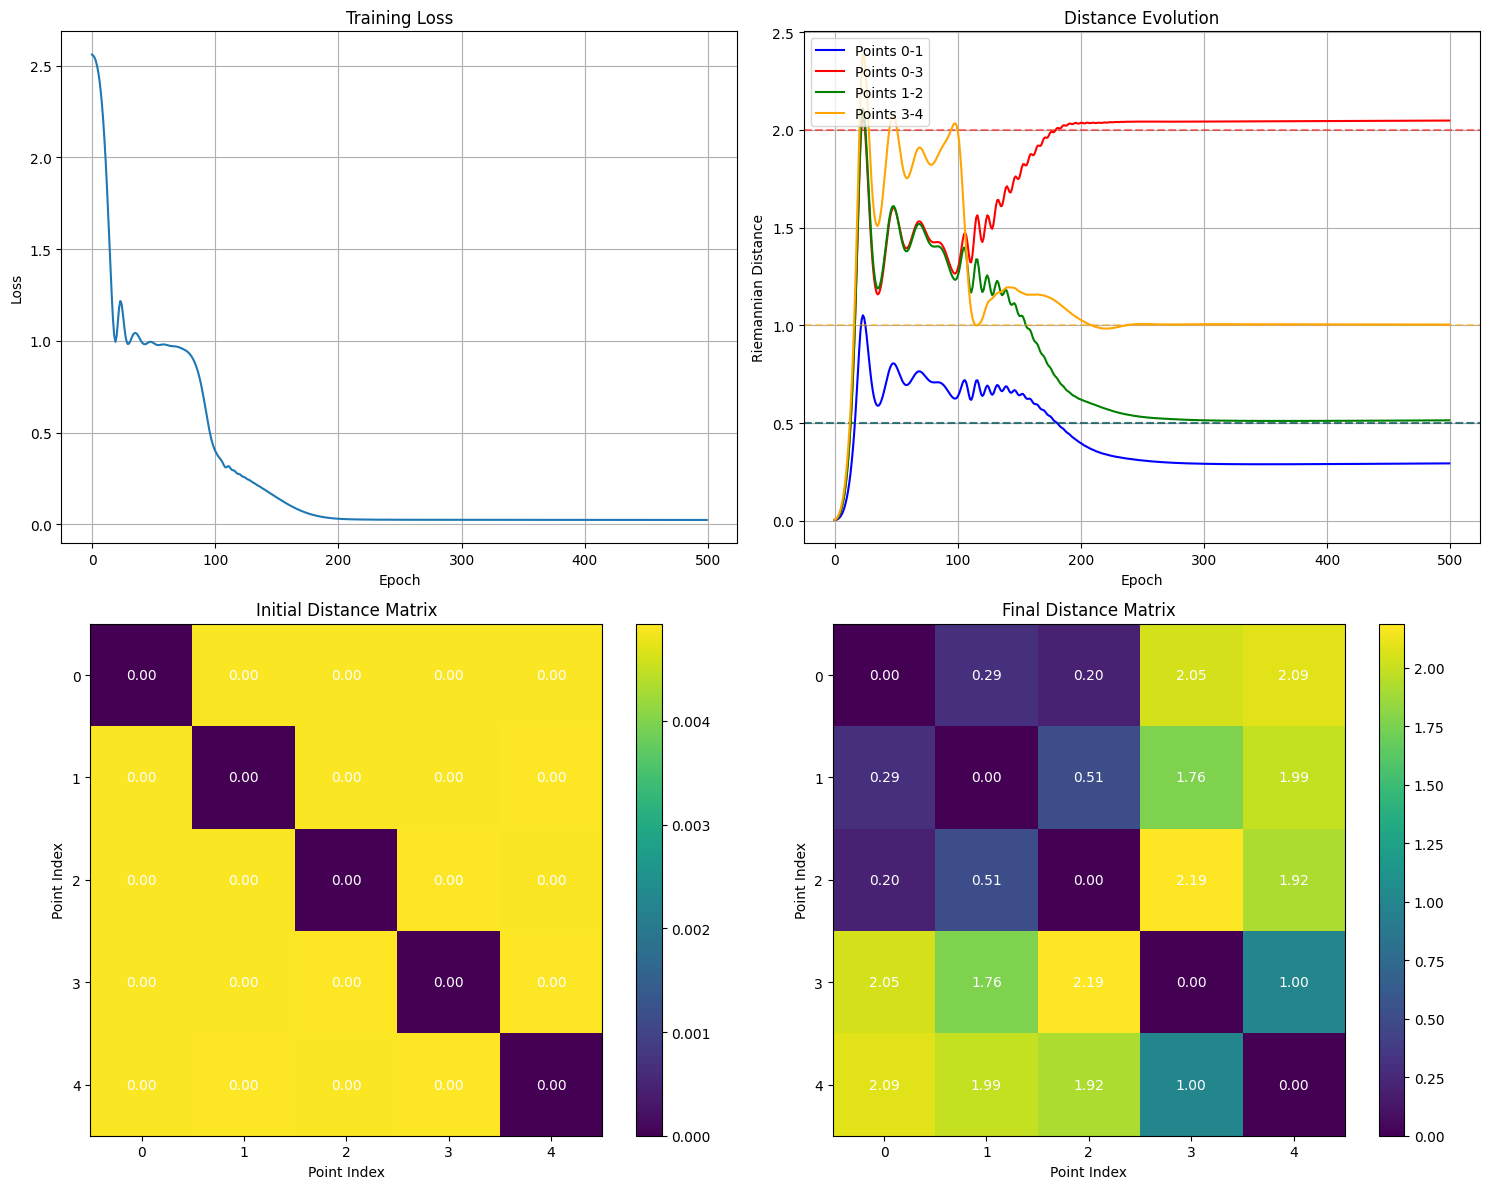

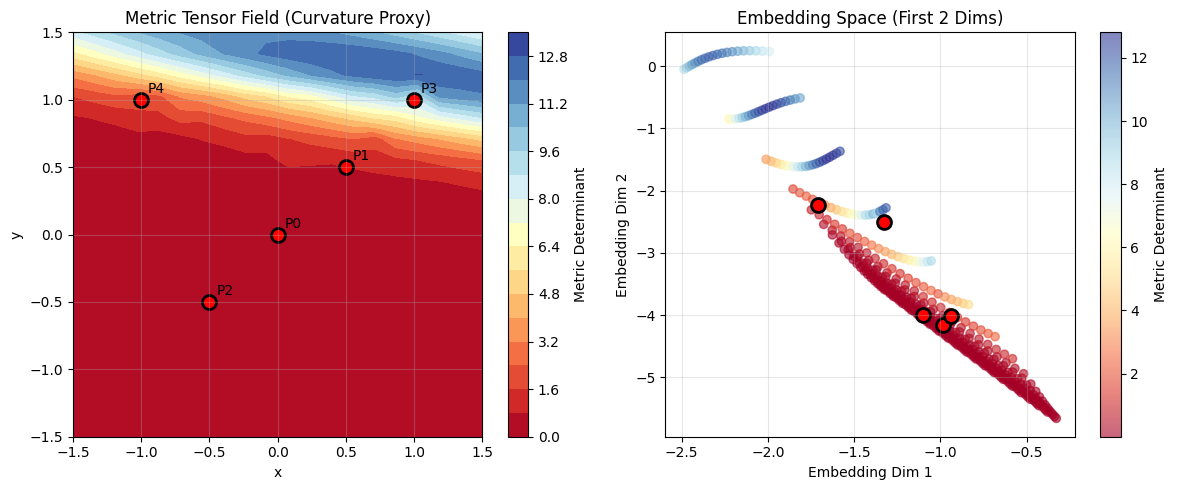

: 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import seaborn as sns
from typing import Dict, Tuple, List
import hashlib
from tqdm import tqdm

class MLP(nn.Module):
    """Simple MLP that defines our manifold embedding"""
    def __init__(self, input_dim=2, hidden_dim=256, output_dim=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

        for layer in self.net:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight, gain=0.1)
    
    def forward(self, x):
        return self.net(x)
    
class MetricTensorCache:
    """Dense, flat-vector cache for metric tensors on a regular grid with autograd per epoch."""
    def __init__(self, grid_size=50, bounds=None, device=None):
        # Device handling
        self.device = torch.device(device) if device is not None else torch.device('cpu')

        # Grid config
        self.grid_size = grid_size
        if bounds is None:
            b = torch.tensor([[-1.5, 1.5], [-1.5, 1.5]], dtype=torch.float32)
        else:
            b = bounds.clone().float()
        self.bounds = b.to(self.device)
        self.n_dims = self.bounds.size(0)

        # Precompute steps and strides for flattening
        self.steps = (self.bounds[:,1] - self.bounds[:,0]) / self.grid_size
        self.inv_steps = 1.0 / self.steps
        # strides for a (grid_size+1)^n indexing
        sizes = [self.grid_size + 1] * self.n_dims
        self._strides = [1]
        for s in reversed(sizes[:-1]):
            self._strides.insert(0, self._strides[0] * s)
        self._strides = torch.tensor(self._strides, dtype=torch.long, device=self.device)
        self._total_grid = torch.prod(torch.tensor(sizes, device=self.device)).item()

        # Cache storage (flat)
        self.cache_flat = None   # shape [total_grid, *metric_shape]
        self.mask_flat = None    # shape [total_grid], bool
        self.metric_shape = None
        self.current_hash = None

        # Stats
        self.hits = self.misses = self.total_requests = 0
        self._full_computed = False

    def _model_hash(self, model):
        return 'epoch_state'

    def _check_hash(self, model_hash):
        if model_hash != self.current_hash:
            self.clear()
            self.current_hash = model_hash

    def _ravel_index(self, point):
        # compute integer grid indices and flatten
        pt = point.to(self.device).float()
        rel = (pt - self.bounds[:,0]) * self.inv_steps
        idx = torch.clamp(torch.round(rel), 0, self.grid_size).long()
        # dot with strides
        return int((idx * self._strides).sum().item())

    def get_metric_tensor(self, point, model):
        self.total_requests += 1
        self._check_hash(self._model_hash(model))

        flat_idx = self._ravel_index(point)
        if self.cache_flat is not None and self.mask_flat[flat_idx]:
            self.hits += 1
            return self.cache_flat[flat_idx].clone()

        self.misses += 1
        g = compute_metric_tensor(point.to(self.device), model)

        # Lazy init flat storage
        if self.cache_flat is None:
            self.metric_shape = tuple(g.shape)
            shape = [self._total_grid] + list(self.metric_shape)
            self.cache_flat = torch.empty(*shape, device=self.device)
            self.mask_flat = torch.zeros(self._total_grid, dtype=torch.bool, device=self.device)

        # store and return
        self.cache_flat[flat_idx] = g
        self.mask_flat[flat_idx] = True
        return g.clone()

    def clear(self):
        """Reset cache and stats"""
        self.cache_flat = None
        self.mask_flat = None
        self.metric_shape = None
        self.current_hash = None
        self.hits = self.misses = self.total_requests = 0
        self._full_computed = False

    def get_stats(self):
        hit_rate = self.hits / max(self.total_requests, 1)
        cached = int(self.mask_flat.sum().item()) if self.mask_flat is not None else 0
        return {
            'hit_rate': hit_rate,
            'hits': self.hits,
            'misses': self.misses,
            'total_requests': self.total_requests,
            'cached_points': cached,
            'total_grid_points': self._total_grid
        }

    def compute_full_grid_metric_tensor(self, model, force=False, batch_size=None):
        self._check_hash(self._model_hash(model))
        if not force and self._full_computed:
            print("Full grid already computed for current epoch.")
            return

        # Generate all grid points
        coords = [torch.linspace(self.bounds[d,0], self.bounds[d,1], self.grid_size+1, device=self.device)
                  for d in range(self.n_dims)]
        meshes = torch.meshgrid(*coords, indexing='ij')
        flat_pts = torch.stack([m.flatten() for m in meshes], dim=1)
        total = flat_pts.size(0)
        print(f"Computing metric tensors for {total} grid points...")

        # If compute_metric_tensor supports batching, do so
        if batch_size and hasattr(compute_metric_tensor, '__call__'):
            for start in tqdm(range(0, total, batch_size), desc="Batched grid compute"):
                end = min(start + batch_size, total)
                batch = flat_pts[start:end]
                gs = compute_metric_tensor(batch, model)  # expect [B, *metric_shape]
                for i, g in enumerate(gs):
                    idx = self._ravel_index(batch[i])
                    self.cache_flat[idx] = g
                    self.mask_flat[idx] = True
        else:
            for p in tqdm(flat_pts, desc="Grid compute"):
                idx = self._ravel_index(p)
                if self.mask_flat is not None and self.mask_flat[idx] and not force:
                    continue
                g = compute_metric_tensor(p, model)
                if self.cache_flat is None:
                    self.metric_shape = tuple(g.shape)
                    shape = [self._total_grid] + list(self.metric_shape)
                    self.cache_flat = torch.empty(*shape, device=self.device)
                    self.mask_flat = torch.zeros(self._total_grid, dtype=torch.bool, device=self.device)
                self.cache_flat[idx] = g
                self.mask_flat[idx] = True

        self._full_computed = True
        print(f"Completed. Cached {int(self.mask_flat.sum().item())} / {total} points.")


def compute_metric_tensor(point, model):
    """Compute metric tensor g_ij = sum_k (∂f_k/∂x_i)(∂f_k/∂x_j)"""
    point = point.clone().detach().requires_grad_(True)
    
    # Forward pass
    output = model(point.unsqueeze(0))
    
    # Compute Jacobian
    jacobian = torch.zeros(output.shape[1], point.shape[0])
    for i in range(output.shape[1]):
        grad = torch.autograd.grad(output[0, i], point, 
                                 create_graph=True, retain_graph=True)[0]
        jacobian[i] = grad
    
    # Metric tensor g_ij = J^T J
    g = torch.mm(jacobian.t(), jacobian)
    return g

def riemannian_distance_discretized(p1, p2, model, cache, num_steps=50):
    """Compute Riemannian distance using discretized path integration"""
    # Linear interpolation between points
    t = torch.linspace(0, 1, num_steps)
    path = p1.unsqueeze(0) + t.unsqueeze(1) * (p2 - p1).unsqueeze(0)
    
    total_distance = 0.0
    
    for i in range(num_steps - 1):
        # Current point and tangent vector
        curr_point = path[i]
        tangent = path[i + 1] - path[i]
        
        # Get metric tensor (cached)
        g = cache.get_metric_tensor(curr_point, model)
        
        # Distance element ds = sqrt(tangent^T g tangent)
        ds = torch.sqrt(torch.dot(tangent, torch.mv(g, tangent)) + 1e-8)
        total_distance += ds
    
    return total_distance

class RiemannianExperiment:
    def __init__(self, grid_size=30, num_points=5):
        self.model = MLP()
        self.cache = MetricTensorCache(grid_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        
        # Generate fixed points on manifold
        self.points = self._generate_points(num_points)
        
        # Target distances (close pairs have small targets, far pairs have large)
        self.target_distances = self._create_target_distances()
        
        # History for visualization
        self.distance_history = []
        self.loss_history = []
    
    def _generate_points(self, num_points):
        """Generate fixed points on manifold"""
        if num_points <= 5:
            # Use predefined points for small cases
            predefined = torch.tensor([
                [0.0, 0.0],    # Center
                [0.5, 0.5],    # Should be close to center
                [-0.5, -0.5],  # Should be close to center
                [1.0, 1.0],    # Should be far from center
                [-1.0, 1.0],   # Should be far from center
            ], dtype=torch.float32)
            return predefined[:num_points]
        else:
            # Generate random points for larger cases
            torch.manual_seed(42)  # Reproducible
            points = torch.randn(num_points, 2) * 0.6  # Scale to reasonable range
            return points
    
    def _create_target_distances(self):
        """Create target distance matrix"""
        n = len(self.points)
        targets = torch.zeros(n, n)
        
        if n <= 5:
            # Use original logic for small cases
            # Points 0,1,2 should be close (target distance ~0.5)
            for i in range(min(3, n)):
                for j in range(min(3, n)):
                    if i != j:
                        targets[i, j] = 0.5
            
            # Points 3,4 should be far from 0,1,2 (target distance ~2.0)
            for i in range(min(3, n)):
                for j in range(3, min(5, n)):
                    targets[i, j] = targets[j, i] = 2.0
            
            # Points 3,4 can be medium distance from each other
            if n >= 5:
                targets[3, 4] = targets[4, 3] = 1.0
        else:
            # For larger cases, create random but consistent targets
            torch.manual_seed(42)
            for i in range(n):
                for j in range(i + 1, n):
                    # Random target between 0.3 and 2.5
                    target = 0.3 + torch.rand(1).item() * 2.2
                    targets[i, j] = targets[j, i] = target
        
        return targets
    
    def compute_all_distances(self):
        """Compute all pairwise Riemannian distances"""
        n = len(self.points)
        distances = torch.zeros(n, n)
        
        for i in range(n):
            for j in range(i + 1, n):
                dist = riemannian_distance_discretized(
                    self.points[i], self.points[j], self.model, self.cache
                )
                distances[i, j] = distances[j, i] = dist
        
        return distances
    
    def compute_loss(self):
        """Compute loss based on target vs actual distances"""
        current_distances = self.compute_all_distances()
        
        # Only consider non-zero target distances
        mask = self.target_distances > 0
        loss = torch.mean((current_distances[mask] - self.target_distances[mask]) ** 2)
        
        det_penalty = 0.0
        sample_points = torch.randn(10, 2) * 0.6 
        for point in sample_points:
            g = self.cache.get_metric_tensor(point, self.model)
            det_g = torch.det(g)
            det_penalty += torch.relu(det_g - 100.0) ** 2  # Penalize det > 5

        loss = loss + 0.5 * det_penalty

        return loss, current_distances
    
    def train_step(self):
        """Single training step"""
        self.optimizer.zero_grad()
        
        loss, distances = self.compute_loss()
        loss.backward()
        self.optimizer.step()
        
        # Store history
        self.loss_history.append(loss.item())
        self.distance_history.append(distances.detach().clone())
        
        return loss.item(), distances
    
    def train(self, epochs=100, precompute_grid=False):
        """Train the model to achieve target distances"""
        print("Training Riemannian manifold curvature...")
        
        # Optionally precompute full grid at start
        if precompute_grid:
            self.cache.compute_full_grid_metric_tensor(self.model)
        
        for epoch in range(epochs):
            loss, distances = self.train_step()
            
            if epoch % 20 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")
                self._print_distance_summary(distances)
                
                # Print cache stats BEFORE clearing
                stats = self.cache.get_stats()
                print(f"Cache: {stats['hit_rate']:.1%} hit rate, {stats['total_grid_points']} entries")
                print()
            
            # Clear cache at end of epoch since model changed
            self.cache.clear()
    
    def _print_distance_summary(self, distances):
        """Print summary of current vs target distances"""
        n = len(self.points)
        print("Distance Summary (Current -> Target):")
        
        if n <= 6:
            # Show all pairs for small cases
            pairs = [(i,j) for i in range(n) for j in range(i+1, n) if self.target_distances[i,j] > 0]
        else:
            # Show only first few pairs for large cases
            pairs = [(0,1), (0,2), (1,2), (0,3)]
            pairs = [(i,j) for i,j in pairs if j < n and self.target_distances[i,j] > 0]
        
        for i, j in pairs:
            curr = distances[i,j].item()
            target = self.target_distances[i,j].item()
            print(f"  Points {i}-{j}: {curr:.3f} -> {target:.3f}")
        
        if n > 6:
            print(f"  ... ({n*(n-1)//2} total pairs)")
        print()
    
    def visualize_curvature_evolution(self):
        """Visualize how curvature (via distances) evolved"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Loss curve
        axes[0,0].plot(self.loss_history)
        axes[0,0].set_title('Training Loss')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].grid(True)
        
        # 2. Distance evolution for key pairs
        epochs = range(len(self.distance_history))
        key_pairs = [(0,1), (0,3), (1,2), (3,4)]
        colors = ['blue', 'red', 'green', 'orange']
        
        for (i,j), color in zip(key_pairs, colors):
            distances = [d[i,j].item() for d in self.distance_history]
            target = self.target_distances[i,j].item()
            
            axes[0,1].plot(epochs, distances, color=color, label=f'Points {i}-{j}')
            axes[0,1].axhline(y=target, color=color, linestyle='--', alpha=0.5)
        
        axes[0,1].set_title('Distance Evolution')
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].set_ylabel('Riemannian Distance')
        axes[0,1].legend()
        axes[0,1].grid(True)
        
        # 3. Initial distance matrix
        initial_distances = self.distance_history[0].numpy()
        im1 = axes[1,0].imshow(initial_distances, cmap='viridis')
        axes[1,0].set_title('Initial Distance Matrix')
        axes[1,0].set_xlabel('Point Index')
        axes[1,0].set_ylabel('Point Index')
        plt.colorbar(im1, ax=axes[1,0])
        
        # Add text annotations
        for i in range(len(self.points)):
            for j in range(len(self.points)):
                axes[1,0].text(j, i, f'{initial_distances[i,j]:.2f}', 
                             ha='center', va='center', color='white')
        
        # 4. Final distance matrix
        final_distances = self.distance_history[-1].numpy()
        im2 = axes[1,1].imshow(final_distances, cmap='viridis')
        axes[1,1].set_title('Final Distance Matrix')
        axes[1,1].set_xlabel('Point Index')
        axes[1,1].set_ylabel('Point Index')
        plt.colorbar(im2, ax=axes[1,1])
        
        # Add text annotations
        for i in range(len(self.points)):
            for j in range(len(self.points)):
                axes[1,1].text(j, i, f'{final_distances[i,j]:.2f}', 
                             ha='center', va='center', color='white')
        
        plt.tight_layout()
        plt.show()
    
    def visualize_metric_tensor_field(self, resolution=20):
        """Visualize the metric tensor field (determinant as curvature proxy)"""
        # Create grid
        x = torch.linspace(-1.5, 1.5, resolution)
        y = torch.linspace(-1.5, 1.5, resolution)
        X, Y = torch.meshgrid(x, y, indexing='ij')
        
        # Compute metric tensor determinant at each point
        det_field = torch.zeros_like(X)
        
        for i in range(resolution):
            for j in range(resolution):
                point = torch.tensor([X[i,j], Y[i,j]], dtype=torch.float32)
                g = self.cache.get_metric_tensor(point, self.model)
                det_field[i,j] = torch.det(g)
        
        # Plot
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.contourf(X.detach().numpy(), Y.detach().numpy(), det_field.detach().numpy(), levels=20, cmap='RdYlBu')
        plt.colorbar(label='Metric Determinant')
        plt.title('Metric Tensor Field (Curvature Proxy)')
        
        # Overlay fixed points
        points_np = self.points.detach().numpy()
        plt.scatter(points_np[:, 0], points_np[:, 1], c='red', s=100, 
                   marker='o', edgecolors='black', linewidth=2)
        for i, (x, y) in enumerate(points_np):
            plt.annotate(f'P{i}', (x, y), xytext=(5, 5), textcoords='offset points')
        
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid(True, alpha=0.3)
        
        # Also show the embedding space
        plt.subplot(1, 2, 2)
        
        # Sample points and their embeddings
        sample_points = torch.stack([X.detach().flatten(), Y.detach().flatten()], dim=1)
        with torch.no_grad():
            embeddings = self.model(sample_points)
        
        # Plot first two dimensions of embedding
        plt.scatter(embeddings[:, 0].detach().numpy(), embeddings[:, 1].detach().numpy(), 
                   c=det_field.detach().flatten().numpy(), cmap='RdYlBu', alpha=0.6)
        plt.colorbar(label='Metric Determinant')
        plt.title('Embedding Space (First 2 Dims)')
        
        # Overlay fixed point embeddings
        with torch.no_grad():
            fixed_embeddings = self.model(self.points)
        plt.scatter(fixed_embeddings[:, 0].detach().numpy(), fixed_embeddings[:, 1].detach().numpy(), 
                   c='red', s=100, marker='o', edgecolors='black', linewidth=2)
        
        plt.xlabel('Embedding Dim 1')
        plt.ylabel('Embedding Dim 2')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

# Run the experiment
def run_experiment(num_points=5):
    print("=== Riemannian Manifold Curvature Optimization Experiment ===\n")
    print(f"Using {num_points} points\n")
    
    # Initialize experiment
    experiment = RiemannianExperiment(num_points=num_points)
    
    # Show initial state
    print("Initial distances:")
    initial_loss, initial_distances = experiment.compute_loss()
    experiment._print_distance_summary(initial_distances)
    print(f"Initial loss: {initial_loss:.4f}\n")
    
    # Train
    experiment.train(epochs=500, precompute_grid=True)
    
    # Show final state
    print("\nFinal distances:")
    final_loss, final_distances = experiment.compute_loss()
    experiment._print_distance_summary(final_distances)
    print(f"Final loss: {final_loss:.4f}")
    
    # Visualizations
    print("\nGenerating visualizations...")
    experiment.visualize_curvature_evolution()
    experiment.visualize_metric_tensor_field()
    
    return experiment

# Run the experiment
if __name__ == "__main__":
    # Try with different numbers of points
    experiment = run_experiment(num_points=5)  # Change this number